# MPlot tutorial

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!


**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed. You can check more examples in [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view). You will also find lots more datasets at his GoogleDrive. [This powerpoint](https://www.slideserve.com/mickie/ucr-time-series-semantic-segmentation-archive-powerpoint-ppt-presentation) explains the content of some of them in a simple way, including the Pulsus Paradoxus dataset.

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)
- `execute_01`. Put this flag to true in case you have never executed the 01_<> notebook for the PulsusParadoxus dataset. Please change it to false one the celss in the section `Execute '1` have already been executed. It does not take very long, but it is some time ;).

In [2]:
#| export
# Configuration paramaters
verbose                       = 1
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1
move_files                    = True

In [3]:
if move_files:
    import _clean_yaml as yml
    import os
    example = "kohl"
    yml.copy_and_verify_yaml(
        wdb_user    = os.getenv("WANDB_ENTITY", "<>"), 
        wdb_project = os.getenv("WANDB_PROJECT", "<>"),
        example = example,
        verbose = 0
    )

In [4]:
print("--- Check parameters ---")
print(
    "verbose (for printing or not messages):", verbose, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
verbose (for printing or not messages): 1 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [5]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [6]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7fb94467c7f0>

















## Generate & Train S3

In [7]:
#-- For setting up the parameters
import os
import torch
from typing import Tuple, Dict

#-- Specific
from ploomber_engine import execute_notebook

##### Ensure the correct configuration for ploomber engine execution

In [8]:
def get_parameters(nb_id : int ) -> Tuple[ str, Dict ]:
    inpath = '~/work/nbs_pipeline'
    outpath = '~/work/nbs_pipeline/output'
    match nb_id:
        case 1:
            filename = "01_dataset_artifact"
            parameters = parameters_01 = {
              'verbose'                       : 0,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 2: 
            filename   = "02b_encoder_MVP"
            parameters = parameters_02 = {
              'verbose'                       : 0,
              'check_memory_usage'            : False,
              'time_flag'                     : False,
              'window_size_percentage'        : None,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 10:
            filename   = "_synthetic_data"
            inpath     = "~/work/nbs"
            parameters = {}
            
        case _:
            print("Invalid configuration")
            filename = ""
            inpath = ""
            outpath = ""
            parameters = {}
    return filename,parameters, inpath, outpath

In [9]:
def get_input_output(
    nb_id   : int
) -> Tuple[ str, str, Dict ]:
    filename,parameter, inpath, outpath = get_parameters(nb_id)
    inbpath    = os.path.expanduser(inpath)
    onbpath    = os.path.expanduser(outpath)
    extension  = ".ipynb"
    reportname = filename+"-output"
    inputnb    = inbpath+"/"+filename+extension
    outputnb   = onbpath+"/"+reportname+extension
    print(f"Executing {inputnb} into {outputnb}")
    return parameter, inputnb, outputnb

In [10]:
# Put to true when you need to restore S3 or whatever
generate = True
execute_01  = False
execute_02  = False

##### Generate S3

In [11]:
if generate:
    parameters, inputnb, outputnb = get_input_output(10)
    print(parameters)
    print(inputnb)
    print(outputnb)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )

Executing /home/macu/work/nbs/_synthetic_data.ipynb into /home/macu/work/nbs_pipeline/output/_synthetic_data-output.ipynb
{}
/home/macu/work/nbs/_synthetic_data.ipynb
/home/macu/work/nbs_pipeline/output/_synthetic_data-output.ipynb


Executing cell: 42: 100%|███████████████████████| 63/63 [00:41<00:00,  1.53it/s]


##### Execute 01: Load artifact to W&B

In [12]:
if execute_01:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

##### Execute 02: Train MTSAE

In [13]:
if execute_02:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(2)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [14]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [15]:
#| export
warnings.filterwarnings("ignore", module="wandb")
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 6
GPU | Used mem: 48
GPU | Memory Usage: [██------------------] 12%


### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [16]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [17]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

### Setup Weights & biases artiffact

In [18]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_S3"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

runname: _MPlot_S3
alias: gtrends_kohl
analysis_mode: online
batch_size: 16
epochs: 200
mask_future: True
mask_stateful: False
mask_sync: False
mvp_ws: (1, 12)
norm_by_sample: False
norm_use_single_batch: False
r: 0.4
stride: 1
train_artifact: mi-santamaria/deepvats/gtrends_kohl:v0
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 12
wandb_group: None


In [19]:
job_type = 'MPlot'
job_type

'MPlot'

## Start W&B Run

In [20]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact

In [21]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")

alias: gtrends_kohl
analysis_mode: online
batch_size: 16
epochs: 200
mask_future: True
mask_stateful: False
mask_sync: False
mvp_ws: [1, 12]
norm_by_sample: False
norm_use_single_batch: False
r: 0.4
stride: 1
train_artifact: mi-santamaria/deepvats/gtrends_kohl:v0
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 12
wandb_group: None
---> W&B Train Artifact


### Transform to dataframe

In [22]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [23]:
#| export
if verbose > 0: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(440, 1)


<bound method NDFrame.head of               volume
2004-01-01  0.010417
2004-01-08  0.010417
2004-01-15  0.010417
2004-01-22  0.000000
2004-01-29  0.000000
...              ...
2012-05-03  0.322917
2012-05-10  0.312500
2012-05-17  0.281250
2012-05-24  0.291667
2012-05-31  0.322917

[440 rows x 1 columns]>

df_train ~  (440, 1)
window_sizes =  [1, 12]
wlen =  12


## Check the MatrixProfile

In [24]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 6
GPU | Used mem: 48
GPU | Memory Usage: [██------------------] 12%


### Initialize parameters

In [25]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [26]:
# Use step for selecting values in position k*step 
ts_step = 1
ts_resampled = df_train.resample('1W').mean()
ts_resampled = ts_resampled.fillna(0)
ts = ts_resampled.iloc[:, 0].values
ts

array([0.010417, 0.010417, 0.010417, 0.      , 0.      , 0.010417,
       0.010417, 0.010417, 0.010417, 0.010417, 0.020833, 0.03125 ,
       0.010417, 0.010417, 0.010417, 0.020833, 0.010417, 0.010417,
       0.020833, 0.020833, 0.010417, 0.010417, 0.020833, 0.010417,
       0.020833, 0.010417, 0.020833, 0.020833, 0.020833, 0.020833,
       0.03125 , 0.020833, 0.020833, 0.03125 , 0.020833, 0.020833,
       0.010417, 0.010417, 0.03125 , 0.03125 , 0.020833, 0.03125 ,
       0.020833, 0.041667, 0.041667, 0.0625  , 0.114583, 0.104167,
       0.09375 , 0.104167, 0.104167, 0.09375 , 0.020833, 0.020833,
       0.020833, 0.010417, 0.020833, 0.020833, 0.020833, 0.020833,
       0.041667, 0.041667, 0.03125 , 0.041667, 0.03125 , 0.041667,
       0.041667, 0.041667, 0.041667, 0.03125 , 0.03125 , 0.03125 ,
       0.041667, 0.052083, 0.041667, 0.041667, 0.03125 , 0.03125 ,
       0.041667, 0.052083, 0.052083, 0.052083, 0.0625  , 0.052083,
       0.0625  , 0.0625  , 0.041667, 0.041667, 0.041667, 0.052

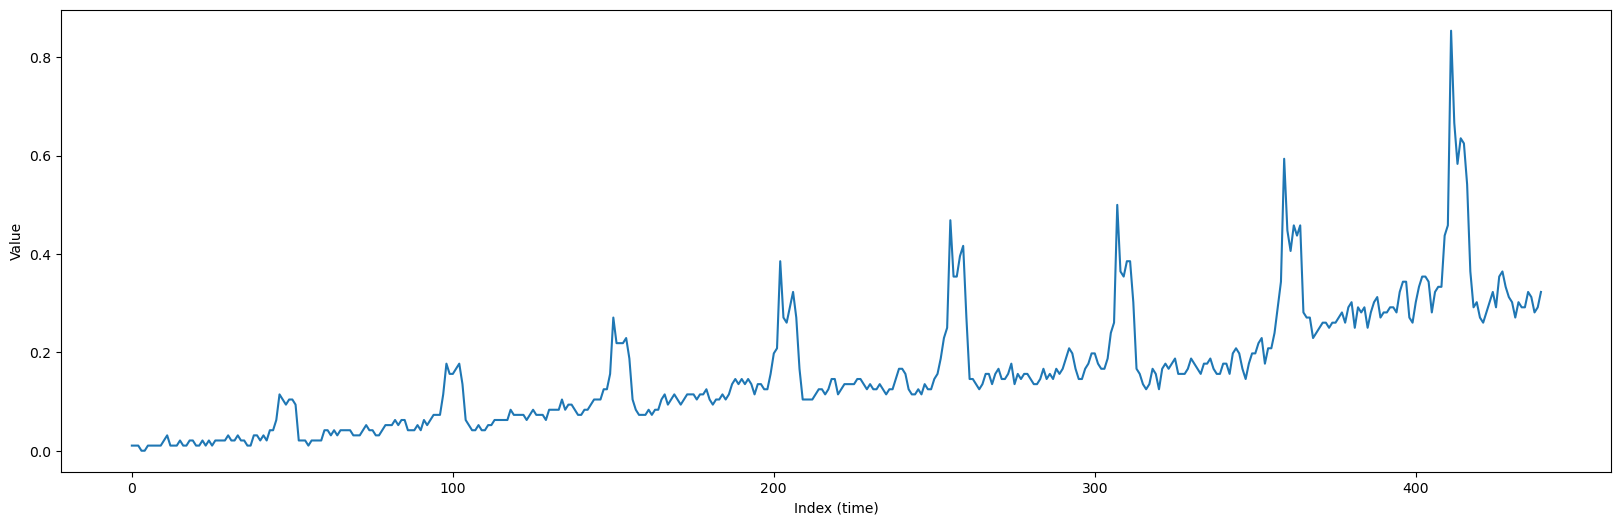

In [27]:
%matplotlib inline
plt.close("all")
mplots.plot_with_dots(
    time_series = ts, 
    title = "", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (20,6),
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10,
    plot_name = "kohl",
    plot_format = "svg"
)

### Build the MatrixProfile object

In [113]:
print(np.mean(ts))
print(np.std(ts))

0.16027464772727273
0.122092045083807


In [28]:
mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

In [29]:
print(len(ts))
x = len(ts)/20
print(x)


440
22.0


### Choose window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [30]:
mp.provide_lens(20)
mp.dominant_lens

[17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18, 12, 20, 12, 5, 11, 5, 2, 11, 8]

In [31]:
m = mp.dominant_lens[0]

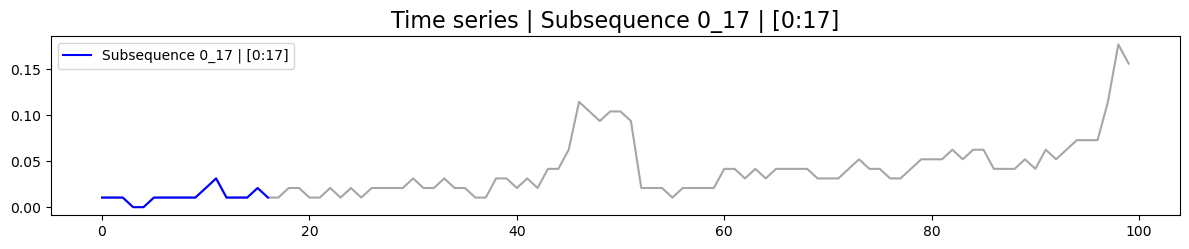

In [32]:
mplots.plot_subsequence(
    TA = ts[:100], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10
)

And what happens if we use the double?

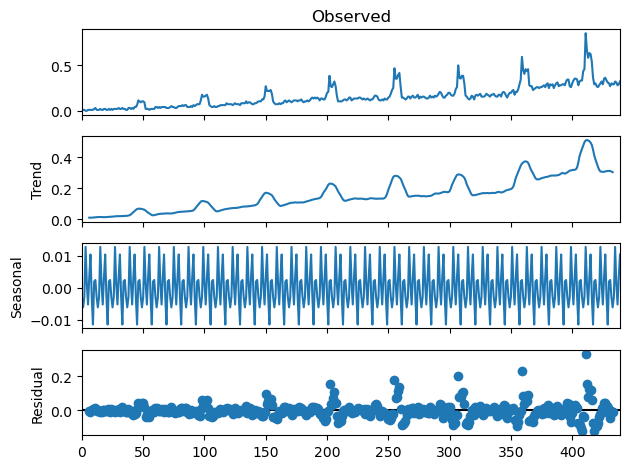

In [35]:
# Little previous check
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts, model = 'additive', period = 12)
decomp.plot()
plt.show()

Number of NaNs in Trend: 12
Number of NaNs in First Difference (d_trend_t): 12
Number of NaNs in Second Difference (dd_trend_t): 12
Threshold: 0.005198944076338713


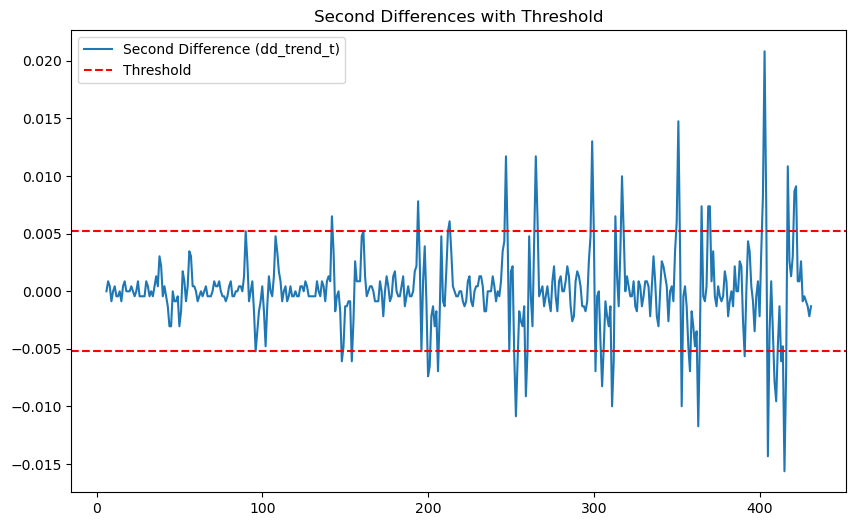

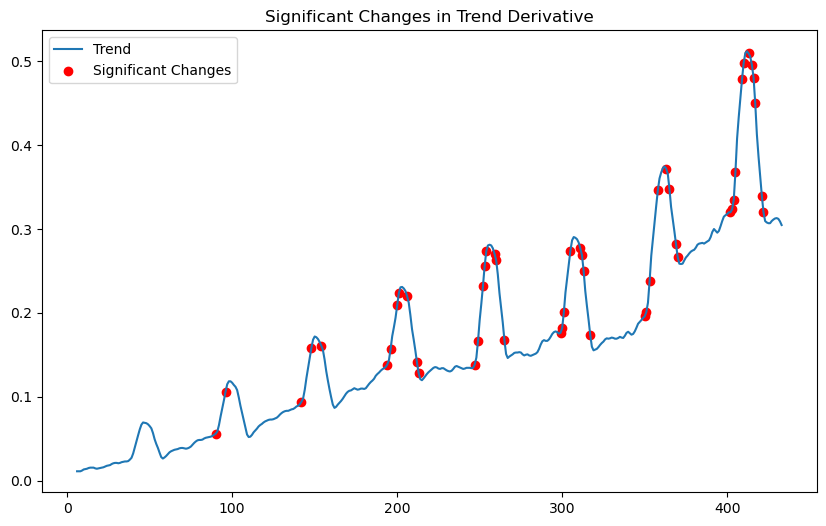

Indices of significant changes: [ 90  96 142 148 154 194 196 200 201 206 212 213 247 249 252 253 254 259
 260 265 299 300 301 305 311 312 313 317 350 351 353 358 363 365 369 370
 402 403 404 405 409 410 413 415 416 417 421 422]


In [55]:
trend = decomp.trend
# d(trend)/dt
d_trend_t = np.diff(trend)
# d(d(trend)/dt)/dt
dd_trend_t = np.diff(d_trend_t)
dd_threshold = np.nanstd(dd_trend_t) * 1.5

# Contar NaNs en cada paso
print("Number of NaNs in Trend:", np.sum(np.isnan(trend)))
print("Number of NaNs in First Difference (d_trend_t):", np.sum(np.isnan(d_trend_t)))
print("Number of NaNs in Second Difference (dd_trend_t):", np.sum(np.isnan(dd_trend_t)))
print("Threshold:", dd_threshold)

plt.figure(figsize=(10, 6))
plt.plot(dd_trend_t, label="Second Difference (dd_trend_t)")
plt.axhline(y=dd_threshold, color="red", linestyle="--", label="Threshold")
plt.axhline(y=-dd_threshold, color="red", linestyle="--")
plt.legend()
plt.title("Second Differences with Threshold")
plt.show()

      
indices = np.where((np.abs(dd_trend_t) > dd_threshold) & (d_trend_t[:-1]*d_trend_t[1:] > 0))[0]
#indices = indices[6:12]
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend')
plt.scatter(indices, trend[indices], color='red', label='Significant Changes')
plt.legend()
plt.title("Significant Changes in Trend Derivative")
plt.show()

# Imprimir los índices detectados
print("Indices of significant changes:", indices)

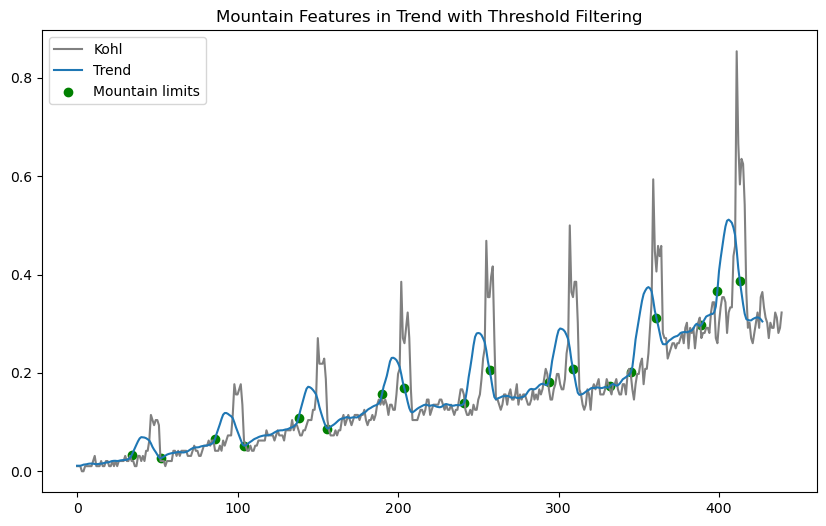

Mountain Indices: [34, 52, 86, 104, 138, 156, 190, 204, 241, 257, 294, 309, 332, 345, 361, 389, 399, 413]


In [107]:
delta = 9
# Eliminar valores NaN de la tendencia
trend = trend[~np.isnan(trend)]

# Cálculo de diferencias
d_trend_t = np.diff(trend)  # Primera diferencia (pendiente)
dd_trend_t = np.diff(d_trend_t)  # Segunda diferencia (cambio en la pendiente)

# Establecer un umbral basado en la segunda derivada
dd_threshold = np.nanstd(dd_trend_t) * 0.8 # Ajusta el multiplicador según la sensibilidad deseada

raw_mountain_limits = [
    i + 1 for i in range(1, len(d_trend_t))  # Empezamos en 1 para comparar con el anterior
    if (d_trend_t[i] - d_trend_t[i - 1] > dd_threshold)  # Cambio abrupto hacia arriba
]
mountain_limits = [raw_mountain_limits[0]]
for idx in raw_mountain_limits[1:]:
    if (idx - mountain_limits[-1]) > delta:  # Comprobar la distancia con el último índice añadido
        mountain_limits.append(idx)


# Gráfica para visualizar los puntos detectados
plt.figure(figsize=(10, 6))
plt.plot(ts, label ='Kohl', color = 'gray')
plt.plot(trend, label='Trend')
plt.scatter(mountain_limits, trend[mountain_limits], color='green', label='Mountain limits')
plt.legend()
plt.title("Mountain Features in Trend with Threshold Filtering")
plt.show()

# Imprimir los índices detectados
print("Mountain Indices:", mountain_limits)


In [111]:
# Most near are the first three mountains
m1 = mountain_limits[1]-mountain_limits[0]
m2 = mountain_limits[3]-mountain_limits[2]
m3 = mountain_limits[5]-mountain_limits[4]
print(f"Posible good distances: {m1}, {m2}, {m3}")

Posible good distances: 18, 18, 18


[40, 90, 148, 196, 249, 300, 351, 403]


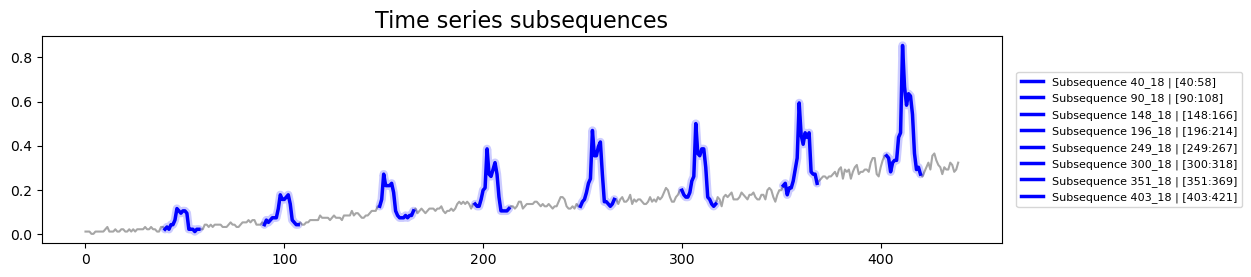

In [112]:
#print(len(ts)-len(trend))
poss   = [mountain_limits[0]+6, indices[0], indices[3], indices[6], indices[13], indices[21], indices[29], indices[37]]
print(poss)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = poss,
    subsequence_len = m1,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10,
    resalt = True,
    anchor_pos =  (1.25, 0.5),
    legend_loc = "center right",
    anchor_right = 0.9,
    legend_size = 8
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

### Compute the Matrix Profile

In [33]:
mp.subsequence_len = m

In [34]:
mp.compute(
    verbose = 1, 
    d = mplots.z_normalized_euclidean_distance, 
    method = 'stump'
)

[ Matrix Profile ] Compute | subsequence_len: 96
--> matrix profile
--> Stump (CPU)
MP | Compute | Using stumpy.stump | normalize? True
matrix profile 30.750373125076294 seconds -->


array([2.816434894786101, 2.784647691565261, 2.729631252882921,
       2.3790106299201255, 2.2538767398470205, 2.1513253220043276,
       2.0828636133519516, 2.0106510435528433, 1.957759727078217,
       1.9586090157824336, 1.963404657398885, 1.9421024162124727,
       1.9041072680985252, 1.9384207606896144, 1.9490754308062403,
       1.9527055735954089, 1.9573505686479769, 1.9638367420344782,
       1.9735343016418017, 1.966581539049472, 1.9498307666719619,
       1.9551282992666503, 1.9470926009858214, 2.0142293149935204,
       2.0696864919069102, 2.0607313454873424, 2.072323347341376,
       2.0749436674361625, 2.099779299488919, 2.11888324990684,
       2.1427273520123706, 2.1455511872261326, 2.1626786213320552,
       2.1590704383737855, 2.1710198330687644, 2.239651967957005,
       2.3069629105588945, 2.335938812110716, 2.372806881295944,
       2.4953737288234286, 2.5065997970450593, 2.5133108777429576,
       2.5158875154542284, 2.4893331220332073, 2.542084289512904,
       2.

In [35]:
len(mp.index)

345

### Visualization of the matrix profile

With the interactive plot we can visually check the motif and anomaly indexes.
The previous and next buttons can be used for going subsequence by subsequence whereas the Motif and Discord buttons show the associated subsequences.

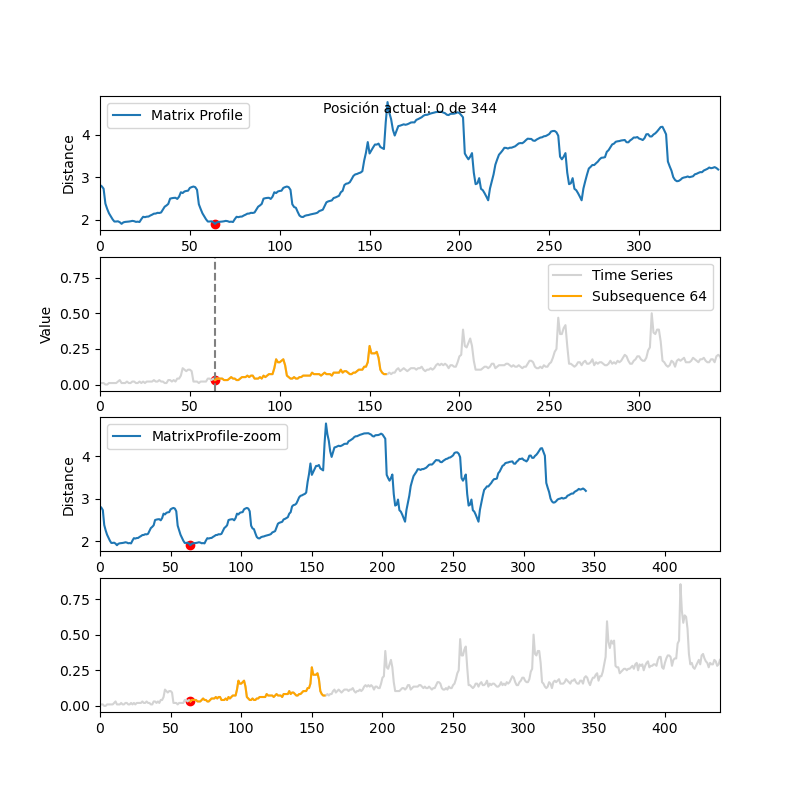

In [36]:
%matplotlib widget
mp.plot_interactive(
    figsize = (8,8),
    verbose =  0
)

### Direct computation & related metadata

#### Motif

In [37]:
mp.get_motif_idx(verbose = verbose)

motif id 64 index ~  345


(64, 12, 12, 116)

In [38]:
print(mp.motif_idx)
print(mp.motif_nearest_neighbor_idx)
print(mp.motif_nearest_neighbor_idx_left)
print(mp.motif_nearest_neighbor_idx_right)


64
12
12
116


#### Discord/Anomaly

In [39]:
mp.get_anomaly_idx(verbose = verbose)

motif id 160 index ~  345
Nearest  264
Nearest left  107
Nearest right  264


(160, 264, 107, 264)

In [40]:
print(mp.discord_idx)
print(mp.discord_nearest_neighbor_idx)
print(mp.discord_nearest_neighbor_idx_left)
print(mp.discord_nearest_neighbor_idx_right)

160
264
107
264


## Check the MPlot

### Build the MatrixProfilePlot object

In [41]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = mp.subsequence_len,
    self_join       = False
)

In [42]:
#| hide
print("MP_AB self_join", data_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {data_MPlot.DM_AB.shape}")
print("MP_AB method:", data_MPlot.MP_AB.method)
print("DM_AB method:", data_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


### Compute the Similarity Matrix

In [43]:
data_MPlot.subsequence_len

96

In [44]:
# z-normalized euclidean distance
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import correlation
from scipy.spatial.distance import cityblock
def zeuclidean(u,v): return euclidean(zscore(u), zscore(v));
def distance(u,v):
    #-- euclidean
    #return euclidean(u,v)
    #-- z_normalized euclidean
    #return zeuclidean(u,v)
    #-- Pearson correlation
    #return correlation(u,v)
    return cityblock(u,v)

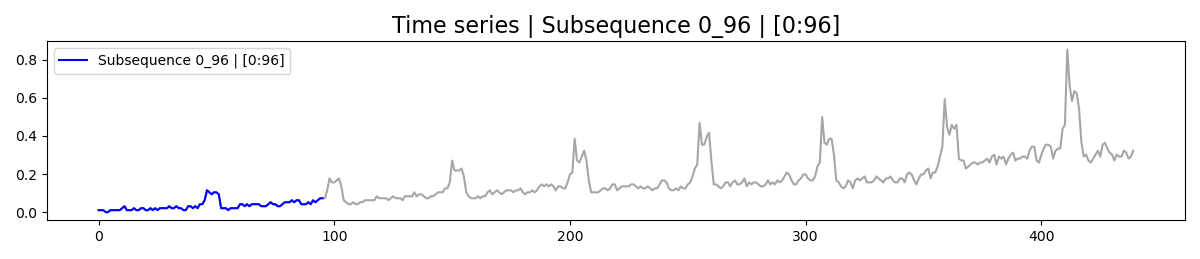

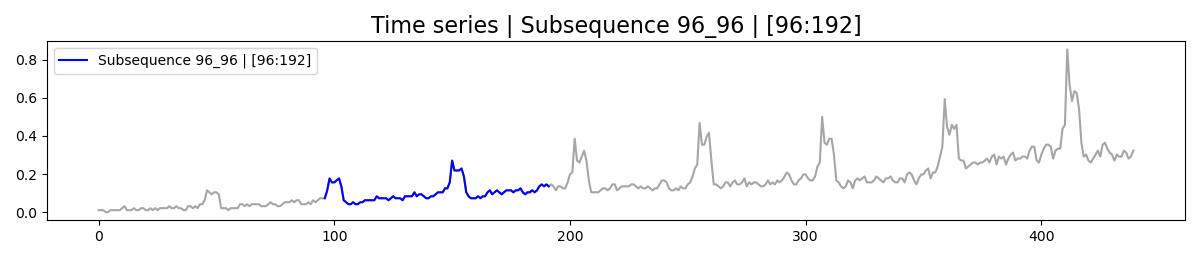

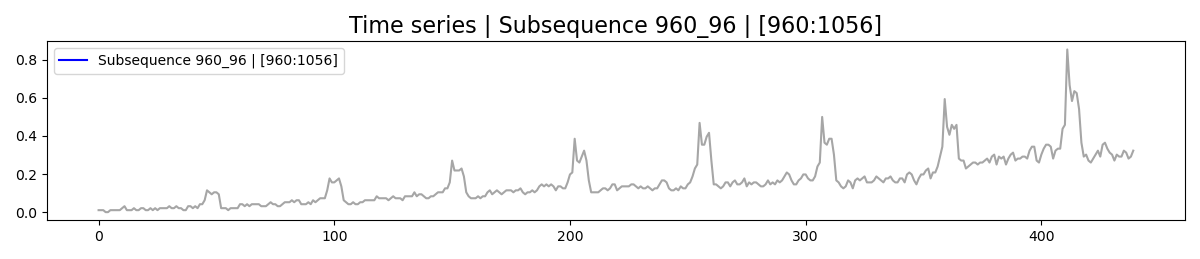

In [45]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = m,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 10*m,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10
)

In [46]:
print(euclidean(ts[0:m], ts[m:m+m]))
print(euclidean(ts[m:m+m], ts[10*m:10*m+m]))
print(euclidean(ts[0:m], ts[10*m:10*m+m]))

0.8246946994112427


ValueError: operands could not be broadcast together with shapes (96,) (0,) 

In [ ]:
print(zeuclidean(ts[0:m], ts[m:m+m]))
print(zeuclidean(ts[m:m+m], ts[10*m:10*m+m]))
print(zeuclidean(ts[0:m], ts[10*m:10*m+m]))

In [ ]:
print(correlation(ts[0:m], ts[m:m+m]))
print(correlation(ts[m:m+m], ts[10*m:10*m+m]))
print(correlation(ts[0:m], ts[10*m:10*m+m]))

In [ ]:
print(cityblock(ts[0:m], ts[m:m+m]))
print(cityblock(ts[m:m+m], ts[10*m:10*m+m]))
print(cityblock(ts[0:m], ts[10*m:10*m+m]))

Para tendencias parece que mejor la euclidiana o la correlation

z-euclidean mata las tendencias
SCAMP no permite modificar la ditancia
Probando con:
- stump y euclidean
- Naive y distancia manhattan (cityblock)
- Naive y distancia específica

In [ ]:
data_MPlot.compute(
    mp_method           = 'stump', 
    dm_method           = 'stump',
    d                   = euclidean,
    #dm_method           = 'scamp',
    #d                   = z_normalized_euclidean_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

### Check the obtained values

In [ ]:
print(data_MPlot.subsequence_len)

In [ ]:
n_a = len(data_MPlot.data)
n_b = len(data_MPlot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - data_MPlot.subsequence_len + 1)
print("Columns: ", n_a - data_MPlot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {data_MPlot.DM_AB.method} --")
print(data_MPlot.DM_AB.shape)
print(f"-- MP dimension using {data_MPlot.MP_AB.method}")
print(len(data_MPlot.MP_AB.distances))
print("-- DM Values --")
print(data_MPlot.DM_AB.distances)
print("-- MP values --")
print(data_MPlot.MP_AB.distances)

### Visualize the plot

##### Motif found by MP

In [ ]:
print("Motif found using MP")
data_MPlot.MP_AB.get_motif_idx()
print(data_MPlot.MP_AB.motif_idx)

init = data_MPlot.MP_AB.motif_idx - m
final = init+3*m
print(f"Plotted: ts[{init},{final}] => {data_MPlot.MP_AB.motif_idx} subsequence index changes to {data_MPlot.MP_AB.motif_idx-init}")

mplots.plot_subsequence(
    TA = ts[init:final],
    sequence_i = data_MPlot.MP_AB.motif_idx-init,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    color = "orange",
    plot_resolution = 10
)


In [ ]:
%matplotlib widget
# Max points to plot
data_MPlot.MP_AB.max_points = 3000
data_MPlot.MP_AB.plot_interactive(verbose = 1, figsize=(8,7))

#### Setting up a threshold

It has been checked that, at least for pulsus raxodus, STUMP separates more the distances than SCAMP, so the proposed thresholds show similar plots for the specific case.

In [ ]:
# Threshold per method
threshold_scamp = 10
threshold_stump = 7.5
# Select the threshold for the method used for the computation
threshold = threshold_stump if data_MPlot.DM_AB.method == 'stump' else threshold_scamp

#### Visualizing the MPlot in gray scale

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;TODO: check, the gray_color flag is in the opposite way... 
    </div>
</div>

- El patrón es el mismo, cada vez un poco más para arriba
- Eso significa que la distancia debe ser cada vez un poco mayor entre unos y otros (en este caso de manera constante)
- Si miro una fila/columna de la matriz de similitud, debería ser cada número (saltando de m en m) un poco mayor que el siguiente
- En los colores se debería ver cada vez más distancia entre unos y otros. 

In [ ]:
print(data_MPlot.DM_AB.distances[0][0:m+1])
print(data_MPlot.DM_AB.distances[0][m:2*m+1])
total = len(data_MPlot.DM_AB.distances[0])
print(data_MPlot.DM_AB.distances[0][total:total-m+1])


In [ ]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = f'S3 | MPlot | {data_MPlot.DM_AB.method} | euclidean distance',
    plot_mp_flag= False,
    gray_color  = False,
    verbose     = 0,
    plot_name   = f'example_s3_mplot_{data_MPlot.DM_AB.method}_euclidean_distance',
    save_plot   = True,
    plot_format = 'svg',
    plot_path   = "./images",
    plot_resolution = 10
)

In [ ]:
data_MPlot_scamp = copy(data_MPlot)
data_MPlot_scamp.compute(
    mp_method           = 'stump', 
    dm_method           = 'scamp',
    d                   = z_normalized_euclidean_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot_scamp.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = f'S3 | MPlot | {data_MPlot_scamp.DM_AB.method} | z-normalized euclidean distance',
    plot_mp_flag= False,
    gray_color  = False,
    verbose     = 0,
    plot_name   = f'example_s3_mplot_{data_MPlot_scamp.DM_AB.method}_znormalized_euclidean_distance',
    save_plot   = True,
    plot_format = 'svg',
    plot_path   = "./images",
    plot_resolution = 10
)

#### Tratando de definir una distancia buena para ver tendencias

##### CityBlock

In [ ]:
def manhattan(
    vector_a    = np.array([0]),
    vector_b    = np.array([0]), 
    verbose     = 0,
    time_flag   = False
):
    t = 0
    if time_flag: 
        timer = dvats.utils.Time()
        timer.start()
        
    if verbose > 0: 
        print(f"Vectors: a: {vector_a} b: {vector_b}")
    distance = cityblock(vector_a, vector_b)
    if time_flag:
        timer.end()
        t = timer.duration()
    return distance, t

In [ ]:
data_MPlot_trend_manhattan = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = mp.subsequence_len,
    self_join       = False
)

##### Trying to be able to detect both up and down trends

In [ ]:
plt.close("all")
mplots.plot_with_dots(
    time_series = ts[::-1], 
    #title = "S3 [::-1]", 
    title = "", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (20,6),
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10,
    plot_name = "s3_inverse",
    plot_format = "svg"
    
)
mplots.plot_subsequence(
    TA = ts[::-1], 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10
)
mplots.plot_subsequence(
    TA = ts[::-1], 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    plot_resolution = 10
)

In [ ]:
ts_ = ts[::-1]
print("Euclidean")
print(euclidean(ts_[0:m], ts_[m:m+m]))
print(euclidean(ts_[m:m+m], ts_[10*m:10*m+m]))
print(euclidean(ts_[0:m], ts_[10*m:10*m+m]))

In [ ]:
def height_distance(#The no-distance with sign
    vector_a    = np.array([0]),
    vector_b    = np.array([0]),
    verbose     = 0,
    time_flag   = False
): 
    t = 0
    if time_flag:
        timer = dvats.utils.Time()
        timer.start()
    if verbose > 0:
        print(f"Vectors: a: {vector_a} b: {vector_b}")
    mean_u      = vector_a.mean()
    mean_v      = vector_b.mean()
    no_distance = mean_u -mean_v
    if time_flag: 
        timer.end()
        t = timer.duration()
    return no_distance, t

In [ ]:
print("Height TS_")
print(height_distance(vector_a = ts_[0:m], vector_b = ts_[m:m+m], verbose = 1, time_flag = True))
print(height_distance(ts_[m:m+m], ts_[10*m:10*m+m]))
print(height_distance(ts_[0:m], ts_[10*m:10*m+m]))

In [ ]:
print("Height TS")
print(height_distance(ts[0:m], ts[m:m+m]))
print(height_distance(ts[m:m+m], ts[10*m:10*m+m]))
print(height_distance(ts[0:m], ts[10*m:10*m+m]))

In [ ]:
data_MPlot_trend = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = mp.subsequence_len,
    self_join       = False
)

In [ ]:
data_MPlot_trend.compute(
    mp_method           = 'stump', 
    dm_method           = 'naive',
    d                   = height_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

In [ ]:
data_MPlot_trend.DM_AB.distances

In [ ]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot_trend.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3 | MPlot | ' + data_MPlot_trend.DM_AB.method + ' | height distance ',
    plot_mp_flag= False,
    gray_color  = False,
    verbose     = 1,
    save_plot   = True,
    plot_name   = f's3_mplot_{data_MPlot_trend.DM_AB.method}_height_distance',
    show_flag   = True,
    plot_path   = "./images",
    plot_resolution  = 10
)

Comprobando tendencia a la baja

In [ ]:
data_MPlot_trend_down = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts[::-1], 
    data_b          = ts[::-1],
    subsequence_len = mp.subsequence_len,
    self_join       = False
)

In [ ]:
data_MPlot_trend_down.compute(
    mp_method           = 'stump', 
    dm_method           = 'naive',
    d                   = height_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

In [ ]:
data_MPlot_trend_down.DM_AB.distances

In [ ]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot_trend_down.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    verbose     = 0,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3 [::-1] | MPlot | ' + data_MPlot_trend_down.DM_AB.method + ' | height distance ',
    plot_mp_flag= False,
    gray_color  = False,
    plot_name = f's3inverse_mplot_{data_MPlot.DM_AB.method}_height_distance',
    save_plot = True,
    plot_resolution = 10,
    plot_path = "./images"
)

In [ ]:
run.finish()
if reset_kernel:
    os._exit(00)